Epoch 1/15
28/28 [==============================] - 13s 345ms/step - loss: 0.0703
Epoch 2/15
28/28 [==============================] - 10s 345ms/step - loss: 0.0037
Epoch 3/15
28/28 [==============================] - 10s 344ms/step - loss: 0.0032
Epoch 4/15
28/28 [==============================] - 10s 342ms/step - loss: 0.0033
Epoch 5/15
28/28 [==============================] - 9s 335ms/step - loss: 0.0032
Epoch 6/15
28/28 [==============================] - 9s 335ms/step - loss: 0.0031
Epoch 7/15
28/28 [==============================] - 9s 336ms/step - loss: 0.0030
Epoch 8/15
28/28 [==============================] - 9s 336ms/step - loss: 0.0028
Epoch 9/15
28/28 [==============================] - 9s 336ms/step - loss: 0.0029
Epoch 10/15
28/28 [==============================] - 9s 336ms/step - loss: 0.0028
Epoch 11/15
28/28 [==============================] - 9s 336ms/step - loss: 0.0030
Epoch 12/15
28/28 [==============================] - 9s 337ms/step - loss: 0.0029
Epoch 13/15
28/28 [==

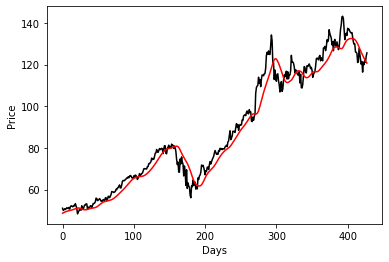

predictionDays:  365 127.88
[4.8677063]


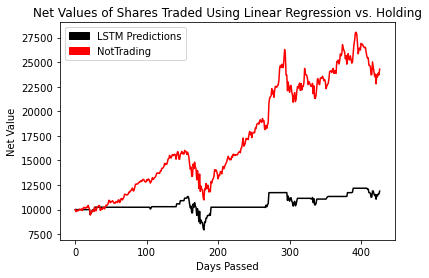

Total Shares:  0.0
Total price:  11876.141302520144
Natural:  24593.84027811781


In [2]:
import torch # PyTorch
import tensorflow as tf # TensorFlow
from tensorflow import keras # Keras
import numpy as np # Numpy
from tqdm import tqdm
from sklearn.model_selection import train_test_split # Easy to use function to split my data
import matplotlib.pyplot as plt # Library for Visualization
from torchvision import datasets, transforms
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import datetime as dt
import pandas_datareader as web
import matplotlib.patches as mpatches

#import data
data_origin = pd.read_csv("Apple5YrData1.csv", sep=",")
data = data_origin.copy()
data['Close/Last'] = data['Close/Last']
data['Close/Last'] = data['Close/Last'].astype('float')
data['Open'] = data['Open'].astype('float')
data['High'] = data['High'].astype('float')
data['Low'] = data['Low'].astype('float')

#get close data
noCloseData = np.array(data.drop(['Close/Last', 'Date'], 1))
closeData = np.array(data['Close/Last'])
predictionDays = 365
predictPrice = [closeData[predictionDays]]


#normalize data
scaler = MinMaxScaler(feature_range=(0,1))
normalizedData = closeData

#split into test and training data
trainingToTestRation = .66
trainDataset,testDataset = normalizedData[:int(len(normalizedData)*trainingToTestRation)], normalizedData[int(len(normalizedData)*trainingToTestRation):]

normalizedTrain = scaler.fit_transform(np.reshape(closeData,(-1,1)))
#set training data
def getTrainingData(data,predictionDays):
    xTrain = []
    yTrain = []
    for x in range(predictionDays, len(data)):
        xTrain.append(data[x-predictionDays:x,0])
        yTrain.append(data[x,0])
    xTrain, yTrain = np.array(xTrain), np.array(yTrain)  
    xTrain = np.reshape(xTrain,(xTrain.shape[0],xTrain.shape[1],1))
    return xTrain, yTrain

xTrain, yTrain = getTrainingData(normalizedTrain,predictionDays)


#LSTM MOdel
LSTMmodel = Sequential()
LSTMmodel.add(LSTM(units = 50,return_sequences = True, input_shape=(xTrain.shape[1],1)))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(LSTM(units = 50,return_sequences = True))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(LSTM(units = 50))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(units=1))

LSTMmodel.compile(optimizer='adam', loss='mean_squared_error')
LSTMmodel.fit(xTrain, yTrain, epochs=15, batch_size=32)

#get input test data
def getTestData(data,predictionDays,trainingToTestRation):
    xTest = []
    totalDataset = np.concatenate((trainDataset,testDataset),axis = 0)
    testInputs = data[(len(totalDataset) - len(testDataset) - predictionDays):]
    testInputs = testInputs.reshape(-1,1)
    testInputs = scaler.transform(testInputs)
    count = 0
    for x in range(predictionDays, len(testInputs)):
        xTest.append(testInputs[x-predictionDays:x,0])
    xTest = np.array(xTest)
    xTest = np.reshape(xTest, (xTest.shape[0],xTest.shape[1],1) )
    return xTest 
testData = getTestData(closeData,predictionDays,trainingToTestRation)

#put through model and get predictions
output = LSTMmodel.predict(testData)
output  = scaler.inverse_transform(output)

dataset = np.concatenate((trainDataset,testDataset),axis = 0)
ActualPrice = closeData[int(len(normalizedData)*trainingToTestRation):]

#plot predictions
plt.plot(ActualPrice , color="black", label=f"Actual Price")
plt.plot(output, color="red", label=f"Predicted Price")
plt.xlabel("Days")
plt.ylabel("Price")
plt.show()


shares = 10000/ActualPrice[0]
cash = 0

print('predictionDays: ', predictionDays, ActualPrice[predictionDays + 1])

netInCash = []
notMoved = []
noMshare = 10000/ActualPrice[0]

for i in range(len(output)-1):
    if output[i+1] > ActualPrice[i]:
        if cash > 0:
            shares = cash / ActualPrice[i]
            cash = 0
    if output[i+1] < ActualPrice[i]:
        if shares > 0:
            cash = shares * ActualPrice[i]
            shares = 0
    if shares > 0:
        netInCash.append(shares*ActualPrice[i])
    else:
        netInCash.append(cash)
    notMoved.append(noMshare*ActualPrice[i])

    
differenceInPredictions = 0
for i in range(len(output)):
    differenceInPredictions = abs(output[i]-ActualPrice[i])
    
    
print(differenceInPredictions)
    
plt.plot(netInCash, color="black", label="Net Cash if trading off predictions")
plt.plot(notMoved, color="red", label="Net Cash from NotTrading")
blackPatch = mpatches.Patch(color="black", label="LSTM Predictions")
redPatch = mpatches.Patch(color="red", label="NotTrading")
plt.legend(handles=[blackPatch, redPatch])
plt.ylabel("Net Value")
plt.xlabel("Days Passed")
plt.title("Net Values of Shares Traded Using Linear Regression vs. Holding")
plt.show()

print("Total Shares: ", shares*ActualPrice[i])
print("Total price: ", cash)
print("Natural: ", noMshare*ActualPrice[i])
